# Load dataset

In [1]:
# Load dataset
import pandas as pd
data = pd.read_csv('banking.csv')

# Have a quick look 
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [2]:
# Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".
import numpy as np
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [3]:
# Delete 'unknown' value

cat_cols = data.select_dtypes(include=object).columns.tolist()

for col in cat_cols:
    # delete each columns that has value 'unknown' 
    index_names = data[ data[col] == 'unknown' ].index 
  
    # drop these row indexes from dataFrame 
    data.drop(index_names, inplace = True) 

In [4]:
data = data.drop("default", axis=1) # drop default 

# Format Data

In [5]:
# Split X and y
X = data.drop('y', axis=1).copy()
y = data['y'].copy()

In [6]:
y.value_counts()

0    26629
1     3859
Name: y, dtype: int64

In [7]:
# One-hot Encoding
cat_cols = data.select_dtypes(include=object).columns.tolist()
X_encoded = pd.get_dummies(X, columns=cat_cols)
X_encoded.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,0,0,0,0,1,0,0,0,0,1
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,0,0,1,0,0,0,0,0,1,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,0,0,1,0,0,0,0,0,0,1
5,30,68,8,999,0,1.4,93.918,-42.7,4.961,5228.1,...,0,0,0,0,0,1,0,0,1,0
6,37,204,1,999,0,-1.8,92.893,-46.2,1.327,5099.1,...,0,0,0,0,1,0,0,0,1,0


In [8]:
# Centering and Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=1818)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Build Support Vector Machine Before Oversampling

In [20]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']}
]
## NOTE: We are including C=1 and gamma='scale'
## as possible choices since they are the default values.

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='roc_auc',
    ##There are other options for this parameter
    ##for example
    ##scoring='f1',
    ##scoring='roc_auc'
    verbose=0
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [10]:
from sklearn.svm import SVC
clf_svm = SVC(random_state=1818, C=10, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.001, random_state=1818)

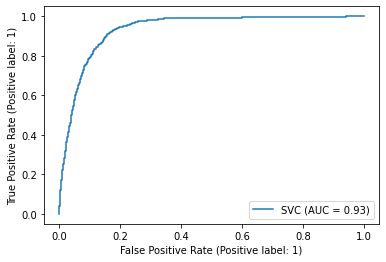

In [15]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(clf_svm, X_test_scaled, y_test) 
plt.savefig("SVM_ROC_before")

# Build Support Vector Machine After Oversampling

In [9]:
from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split

os = SMOTE(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X_encode, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_resample(X_train_scaled, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  39898
Number of no subscription in oversampled data 19949
Number of subscription 19949
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [10]:
X_train_new = os_data_X
y_train_new = os_data_y

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = [
    {'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']}
]
## NOTE: We are including C=1 and gamma='scale'
## as possible choices since they are the default values.

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

optimal_params.fit(X_train_new, y_train_new)
print(optimal_params.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 35.1min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [14]:
from sklearn.svm import SVC
clf_svm_after = SVC(random_state=1818, C=1, gamma=0.1)
clf_svm_after.fit(X_train_new, y_train_new)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(C=1, gamma=0.1, random_state=1818)

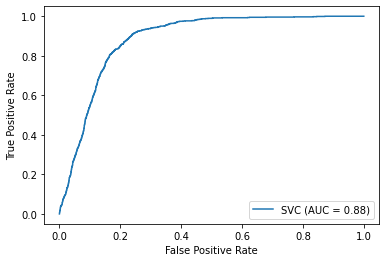

In [17]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(clf_svm_after, X_test_scaled, y_test)